# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация
### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
!unzip ./hw3.zip

Archive:  ./hw3.zip
   creating: data/
   creating: data/external/
  inflating: data/external/jokes.txt  
   creating: src/
  inflating: src/model.py            
  inflating: src/train.py            
   creating: src/__pycache__/
  inflating: src/__pycache__/__init__.cpython-310.pyc  
  inflating: src/__pycache__/dataset.cpython-310.pyc  
  inflating: src/__pycache__/train.cpython-310.pyc  
  inflating: src/__pycache__/model.cpython-310.pyc  
  inflating: src/__init__.py         
  inflating: src/dataset.py          
  inflating: bpe.model               
  inflating: bpe.vocab               


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [85]:
import torch
import numpy as np
from src.dataset import TextDataset

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [8]:
train_set = TextDataset(data_file='data/external/jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='data/external/jokes.txt', train=False, sp_model_prefix='bpe')

In [9]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [48]:
from src.model import LanguageModel

In [44]:
model = LanguageModel(train_set)

In [45]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix)
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (1.5 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

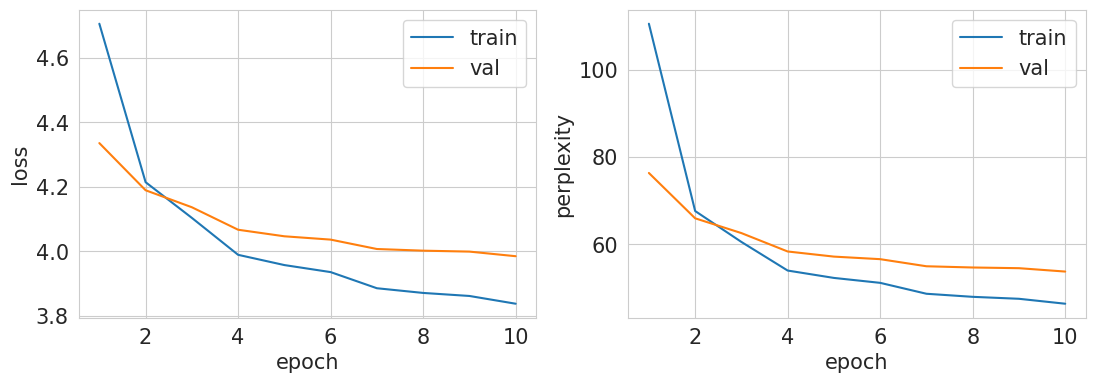

In [46]:
import torch.optim as optim
from torch.utils.data import DataLoader
from src.train import train
from src.model import LanguageModel

model = LanguageModel(train_set)

learning_rate = 0.001
batch_size = 32
num_epochs = 10

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=batch_size)

train(model,
      optimizer,
      scheduler,
      train_loader,
      val_loader,
      num_epochs=num_epochs,
      device=DEVICE)
torch.save(model, "./model_rnn.pt")

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

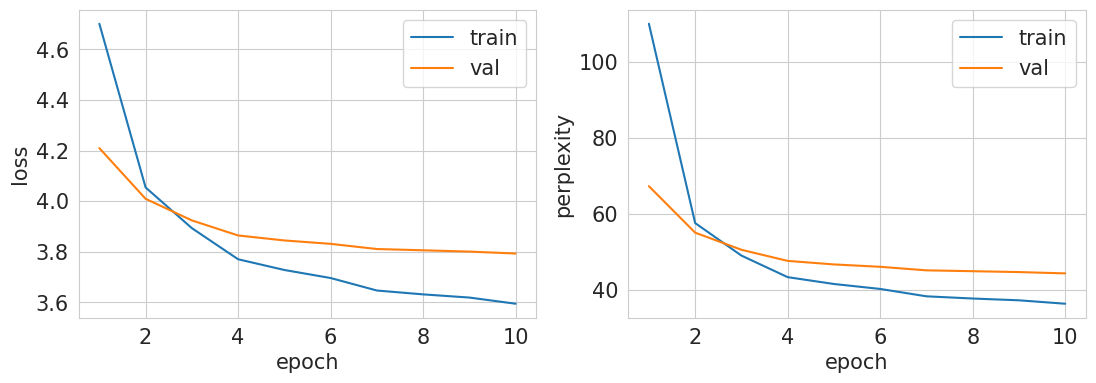

In [49]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch import nn
from src.train import train
from src.model import LanguageModel

model = LanguageModel(train_set, rnn_type=nn.LSTM)

learning_rate = 0.001
batch_size = 32
num_epochs = 10

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=batch_size)

train(model,
      optimizer,
      scheduler,
      train_loader,
      val_loader,
      num_epochs=num_epochs,
      device=DEVICE)
torch.save(model, "./model_lstm.pt")

После изменения рекурентного слоя с RNN на LSTM, метрика улучшилась на 20% (perplexity с ~55 уменьшилось до ~45 на валидационной выборке)

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [59]:
from src.model import LanguageModel
model = torch.load("model_lstm.pt").to(torch.device("cpu")) # Подгрузим модель с LSTM

### Prefix про Штирлица

In [72]:
prefix_shtirlets = "Штирлиц еще никогда не был так близок к провалу"

In [70]:
model.inference(prefix_shtirlets, temp=0.1)

'штирлиц еще никогда не был так близок к провалую горячим наложил.'

In [73]:
model.inference(prefix_shtirlets, temp=0.01)

'штирлиц еще никогда не был так близок к провалую, гладитку в нулевый, это дело для проценты.'

In [74]:
model.inference(prefix_shtirlets, temp=0.001)

'штирлиц еще никогда не был так близок к провалую.'

In [75]:
model.inference(prefix_shtirlets, temp=2)

'штирлиц еще никогда не был так близок к провалу...отс и она родил института.'

In [76]:
model.inference(prefix_shtirlets, temp=20)

'штирлиц еще никогда не был так близок к провалу можешь начинаться девственничности вводить, мне спать приходит домой в наш города, как спать.'

In [77]:
model.inference(prefix_shtirlets, temp=100)

'штирлиц еще никогда не был так близок к провалуут и мертвым детских выборах, тоже сказал, что будете не участинных женщин, на которую будет убить, какого цветческих.'

### Prefix про русского, американца и француза

In [78]:
prefix_rus_us_fr = "Как-то русский, француз и американец"

In [79]:
model.inference(prefix_rus_us_fr, temp=0.1)

'как-то русский, француз и американец- только заварили друзей бить рам.'

In [80]:
model.inference(prefix_rus_us_fr, temp=0.01)

'как-то русский, француз и американец- больной, на улице хорошо, приезжайте на диване и убиваешь. а вам говорят?'

In [81]:
model.inference(prefix_rus_us_fr, temp=0.001)

'как-то русский, француз и американец- чубайсарь большой видом моется мою машину, а утром сложилась во второй, куда хорошо. когда краснеет, бабульчик заглядывает машину. она видит. еще более дракон.'

In [82]:
model.inference(prefix_rus_us_fr, temp=2)

'как-то русский, француз и американец мимо паника нельзя давать у них в зимней семье спализу нулевой?'

In [83]:
model.inference(prefix_rus_us_fr, temp=20)

'как-то русский, француз и американец слушал чащетоп  ⁇ 0 с предупредил.'

In [84]:
model.inference(prefix_rus_us_fr, temp=100)

'как-то русский, француз и американец молока- чему?- да нет, вот купи мужу. вчера наконец-то у меня аварий выбирает и потом жарится.'

В целом, можно сказать, что чем выше температура, тем более длинные ответы генерируются и более неуместные слова и символы появляются в сгенерированном примере. При больший температурах возможно могут появляться новые слова, составленные из подслов

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [89]:
from src.dataset import TextDataset

train_set_bpe_large = TextDataset(data_file='data/external/jokes.txt', train=True, sp_model_prefix='bpe', vocab_size=8000)
valid_set_bpe_large = TextDataset(data_file='data/external/jokes.txt', train=False, sp_model_prefix='bpe', vocab_size=8000)

## Задание 6. Latent Semantic Analysis (1 балл)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.